In [183]:
import numpy as np
import  matplotlib.pyplot as plt
import scipy.special as sp

# source

In [184]:
def source(no_of_users, no_of_bits):
    # Generate a random binary matrix with shape (no_of_users, no_of_bits)
    # Each element is either 0 or 1
    return np.random.randint(0, 2, (no_of_users, no_of_bits))

no_of_users = 2  # Define the number of users
no_of_bits = 8  # Define the number of bits per user

# Generate the message bits as a binary matrix
msg_bits1 = source(no_of_users, no_of_bits) # Generating bit stream of size (no_of_users, no_of_bits)
# Print the generated message bits
print("msg\n", msg_bits1)  # Each row represents the bit stream for one user


msg
 [[0 0 1 1 0 1 1 0]
 [0 1 1 0 1 1 0 1]]


# modulationn

In [185]:
def mod(bits):
    # Map binary values: 0 to -1 and 1 to 1
    return 2 * bits - 1

# Apply modulation to the message bits
symbols = mod(msg_bits1)
print(symbols)

[[-1 -1  1  1 -1  1  1 -1]
 [-1  1  1 -1  1  1 -1  1]]


In [186]:
channel_coeff=np.random.randn(no_of_users,no_of_bits)
print(symbols)
print(channel_coeff)

[[-1 -1  1  1 -1  1  1 -1]
 [-1  1  1 -1  1  1 -1  1]]
[[-0.18612872  0.77702356 -0.05853889  1.17217861  0.34788415  2.46053088
  -1.75467681  0.55639082]
 [ 0.70230394 -0.57989909  0.45514336  0.93798312 -0.168448    0.593718
   0.08268406  0.37194539]]


# channel

In [187]:
def awgn_mac_with_channel_coeff(symbols, snr_db):
    # Sum the columns of the symbols array to combine signals from different users

    #cahnnel coefficienst
    channel_coeff=np.random.randn(no_of_users,no_of_bits)
    
    faded_symbols=symbols*channel_coeff# This corresponds to y = x_i * h_i
    # Print combined symbols for debugging (commented out)
    
    combined_faded_symbols = np.sum(faded_symbols, axis=0)# This corresponds to y = ∑x_i * h_i
    # print(combined_symbols)   
    
    # Calculate the average power of the combined signal
    signal_power = np.mean(np.abs(combined_faded_symbols)**2)  # Signal power calculation

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10.0)
    
    # Calculate noise variance based on the signal power and SNR
    noise_variance = signal_power / (2 * snr_linear)

    # Generate complex Gaussian noise with the calculated variance
    noise = np.sqrt(noise_variance) * np.random.randn(len(combined_faded_symbols))  # Generating noise with accordance with signal power

    #multiplying with channel coeff
    # channel_coeff=np.random.randn(len(combined_symbols))
    # Add the noise to the combined symbols and return the result
    return combined_faded_symbols + noise,channel_coeff

# Define the SNR in dB (array with one value in this case)
snr_db = np.arange(2, 3, 1)

# Pass the modulated symbols through the AWGN channel
received_signal,channel_coeff = awgn_mac_with_channel_coeff(symbols, snr_db)

# Print the received signal after adding noise
print("y=:\n",received_signal,"\n","h_i=",channel_coeff)

y=:
 [-1.40455677 -0.26566754  1.94154369  1.37806646  2.97264294  0.64985972
 -1.08948369  0.97684177] 
 h_i= [[ 0.06934062 -0.35243377  1.59844828 -0.35278121 -1.54642224  1.36462043
   0.2784918  -0.07319248]
 [ 1.6177668  -0.01497448  0.65909821 -0.74211877  0.86408429  0.18655875
   0.50732699  0.57905935]]


# Demodulation

In [188]:
def demod1(received_signal, channel_coeff):
    possible_symbols = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    recovered_sum = []

    # Iterate over the received symbols
    for rec_sym in received_signal:
        # Use min() to find the symbol with the smallest distance
        best_symbol = min(possible_symbols, key=lambda symbol: np.abs(rec_sym - np.sum(channel_coeff[:, 0] * np.array(symbol)))**2)

        # Append the sum of the best symbol to the recovered_sum list
        recovered_sum.append(np.sum(best_symbol))

    return recovered_sum

recovered = demod1(received_signal, channel_coeff)
print("demodulated_sym:", recovered)


demodulated_sym: [0, 0, 2, 0, 2, 0, 0, 0]


In [189]:
def demod(received_signal,channel_coeff):
    possible_symbols=[(-1,-1),(-1,1),(1,-1),(1,1)]
    # print("channel_coeff\n",channel_coeff,"\n\n")
    recovered_sum=[]
    for rec_sym in received_signal:
        min_distance = float('inf')  # Initialize min_distance to a large value
        best_symbol = None  # To keep track of the symbol with the minimum distance
        for i in range(0,len(channel_coeff[0])):
            for j in possible_symbols:
                # print(channel_coeff[:,i],np.array(j))
                hi_xi=channel_coeff[:,i]*np.array(j)
                sum_hi_xi=np.sum(hi_xi)
                # print("∑x_i*h_i=",sum_hi_xi,"\t","y=",rec_sym)
                distance=np.abs(rec_sym-sum_hi_xi)**2
                # print("distance=",distance,"\n\n")
                # Update the minimum distance and corresponding symbol
                if distance < min_distance:
                    min_distance = distance
                    best_symbol =np.array(j)
            # print("min_distance:",min_distance,"best_symb:",best_symbol)    
            # print("---------------------------------------------------------------------")
            break
        recovered_sum.append(np.sum(best_symbol))
    return recovered_sum
 

recovered=demod(received_signal,channel_coeff)
print("demodulated_sym",recovered)

demodulated_sym [0, 0, 2, 0, 2, 0, 0, 0]


## BER calculation

In [190]:
def ber_bpsk_sum_with_fading(msg, recovered):
    # Modulate the original message bits to get the transmitted symbols
    sym1 = mod(msg)
    
    # Sum the transmitted symbols across all users
    combined_symbols = np.sum(sym1, axis=0)  # This is used to compare with the received symbols
    # print("msg:",combined_symbols)
    
    # print("rec:",recovered)
    
    # Print statements for debugging (currently commented out)
    # print(msg)
    # msg_sum = np.sum(msg, axis=0)
    # print("\n", msg_sum)
    # print("\n", rec)

    # Calculate the Bit Error Rate (BER) by comparing the combined transmitted symbols with the received symbols
    ber = np.mean(combined_symbols != recovered)  # BER is calculated by averaging the number of symbol errors
    
    return ber

# Calculate the Bit Error Rate (BER) using the original message bits and the demodulated symbols
BER = ber_bpsk_sum_with_fading(msg_bits1,recovered)

# Print the calculated BER
print(BER)


0.375


## simulation

In [191]:
# Function to simulate the system for different SNR values
def simulate_mac_with_fading(snr_db_range, msg_bits, no_of_users, no_of_bits):
    ber_with_channel_coeff = []  # Initialize an empty list to store Symbol Error Rate (SER) for each SNR value

    # Iterate over the range of SNR values
    for snr_db in snr_db_range:
        # Print the current SNR value for debugging (commented out)
        # print("snr=", snr_db)
        
        # Modulate the message bits to obtain transmitted symbols
        transmitted_symbols = mod(msg_bits)  # Modulation: bit stream --> symbols
        # print(transmitted_symbols)
          
        # Pass the transmitted symbols through the AWGN channel to get received symbols
        received_symbols,faded_symbols = awgn_mac_with_channel_coeff(transmitted_symbols, snr_db)  # Received symbols: channel output = symbols + noise
        # print("received\n",received_symbols)
        
        # Demodulate the received symbols to recover the transmitted symbols
        demodulated_symbols = demod(received_symbols,faded_symbols)  # Demodulation: noisy_symbols --> decoded symbols
        # print("demodulated\n",demodulated_symbols)
        
        # ber_with_channel_coeff=ber_bpsk_sum_with_fading(msg_bits,demodulated_symbols)
        # print(ber_with_channel_coeff)
        ber_with_channel_coeff.append(ber_bpsk_sum_with_fading(msg_bits, demodulated_symbols)) 
        # Demodulate the received symbols to recover the transmitted symbo>
        # print("\n\n")

    return ber_with_channel_coeff   # Return the list of SER values for the given range of SNR values



# Define the range of SNR values (in dB) for the simulation
snr_db_range = np.arange(0, 12, 1)  # Input for SNR range to plot

# Run the simulation to obtain SER for each SNR value
ber_bpsk_sum_with_fading=simulate_mac_with_fading(snr_db_range, msg_bits1, no_of_users, no_of_bits)

# Print the Bit Error Rate (BER) for each SNR value
# print(ber_bpsk_sum_with_channel_coeff)
 

print(ber_bpsk_sum_with_fading)

[0.5, 0.375, 0.375, 0.25, 0.625, 0.375, 0.375, 0.5, 0.625, 0.5, 0.25, 0.5]


### plotting

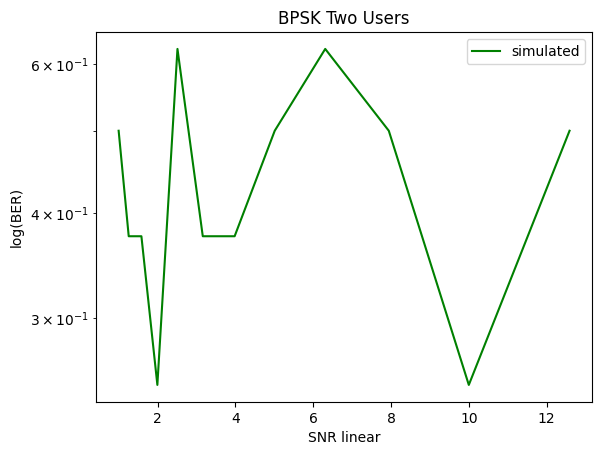

In [192]:
# Convert SNR values from dB to linear scale
snr_lin = 10**(snr_db_range / 10)  # SNR in linear scale


# Plot the simulated BER values
plt.semilogy(snr_lin, ber_bpsk_sum_with_fading, linestyle='-', color="g", label='simulated')

#theoritical values
# plt.semilogy(snr_lin,1/((1*snr_lin)), linestyle='--', color="r", label='theoritical')

plt.xlabel("SNR linear")  
plt.ylabel("log(BER)")       
plt.legend()         
plt.title("BPSK Two Users") 
# plt.grid(True)
plt.show()
